# Psuedobulk functional analysis from DESeq2 contrasts with decoupler
**Authorship:** Adam Klie (last updated: 08/27/2023)<br>
***
**Description:** This notebook performs a

# Set-up

In [27]:
# Global Imports
import os
import sys
import yaml
import logging
import scanpy as sca# Global Imports
import os
import sys
import yaml
import random
import time
import datetime
import logging
import scanpy as sc
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 3

# Local imports
sys.path.append("/cellar/users/aklie/data/igvf/bin")
from utils import make_dirs
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 3

# Local imports
sys.path.append("/cellar/users/aklie/data/igvf/bin")
from utils import make_dirs

In [120]:
# Dataset
dataset_name = "igvf_sc-islet_10X-Multiome"
results_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results"
pseudobulk = "predicted_cell_type_by_condition"
cell_type = "SC_beta"
condition = "Ex4-HG"
batch = None

# Inputs
in_date = "25Aug23"
in_analysis = "pseudobulk_deseq2"
in_run = "3817601312_20230829-105534"
use_shrunk = True
in_file = f"{condition}_vs_control_shrunkLFC.tsv" if use_shrunk else f"{condition}_vs_control.tsv"
if condition:
    if batch:
        in_data = os.path.join(results_dir, dataset_name, in_date, "pseudobulk_analysis", in_analysis, pseudobulk, cell_type, batch, condition.replace("-", "_"),  in_run, in_file)
    else:
        in_data = os.path.join(results_dir, dataset_name, in_date, "pseudobulk_analysis", in_analysis, pseudobulk, cell_type, condition.replace("-", "_"), in_run, in_file)
else:
    if batch:
        in_data = os.path.join(results_dir, dataset_name, in_date, "pseudobulk_analysis", in_analysis, pseudobulk, cell_type, batch, in_run, in_file)
    else
        in_data = os.path.join(results_dir, dataset_name, in_date, "pseudobulk_analysis", in_analysis, pseudobulk, cell_type, in_run, in_file)
print(in_data)

# Outputs
out_date = "25Aug23"
out_analysis = "functional_analysis"
time_id = time.strftime("%Y%m%d-%H%M%S")
run_id =  random.getrandbits(32)
run = str(run_id) + "_" + time_id
if condition:
    if batch:
        out_dir = os.path.join(results_dir, dataset_name, out_date, "pseudobulk_analysis", out_analysis, pseudobulk, cell_type, batch, condition.replace("-", "_"), run)
    else:
        out_dir = os.path.join(results_dir, dataset_name, out_date, "pseudobulk_analysis", out_analysis, pseudobulk, cell_type, condition.replace("-", "_"), run)
else:
    if batch:
        out_dir = os.path.join(results_dir, dataset_name, out_date, "pseudobulk_analysis", out_analysis, pseudobulk, cell_type, batch, run)
    else:
        out_dir = os.path.join(results_dir, dataset_name, out_date, "pseudobulk_analysis", out_analysis, pseudobulk, cell_type, run)
print(make_dirs(out_dir))

# Method params
tf_annotation_resource = "dorothea"
tf_method = "ulm"
tf_additional_args = {}
pathway_annotation_resource = "progeny"
pathway_method = "mlm"
pathway_additional_args = {"top": 500}
gsea_resource = "msigdb"
gsea_method = "ora"
gsea_additional_args = {"padj": 0.05, "top_n": None}

/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome/25Aug23/pseudobulk_analysis/pseudobulk_deseq2/predicted_cell_type_by_condition/SC_beta/Ex4_HG/3817601312_20230829-105534/Ex4-HG_vs_control_shrunkLFC.tsv
/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome/25Aug23/pseudobulk_analysis/functional_analysis/predicted_cell_type_by_condition/SC_beta/Ex4_HG/918428221_20230829-113213


In [121]:
# Make a params file
data_params = {
    "in_data": in_data,
    "pseudobulk": pseudobulk,
    "cell_type": cell_type,
    "condition": condition,
    "batch": batch,
    "out_dir": out_dir
}
tf_activity_params = {
    "tf_annotation_resource": tf_annotation_resource,
    "tf_method": tf_method,
    "tf_additional_args": tf_additional_args,
}
pathway_activity_params = {
    "pathway_annotation_resource": pathway_annotation_resource,
    "pathway_method": pathway_method,
    "pathway_additional_args": pathway_additional_args,
}
gsea_params = {
    "gsea_resource": gsea_resource,
    "gsea_method": gsea_method,
    "gsea_additional_args": gsea_additional_args,
}
version_params = {
    "time_id": time_id,
    "run_id": run_id,
    "Python": sys.version[:5],
    "Scanpy": sc.__version__,
    "decoupler": dc.__version__,
}
params = {"data": data_params, "tf_activity": tf_activity_params, "pathway_activity": pathway_activity_params, "gsea": gsea_params, "version": version_params}
params_file = os.path.join(out_dir,"functional_analysis_params.yaml")
if not os.path.exists(os.path.join(out_dir, params_file)):
    with open(os.path.join(out_dir, params_file), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

# Load data

In [122]:
# The data to load in formatted as a 10x directory, change if you have a different format for reading in data
results_df = pd.read_csv(in_data, sep="\t", index_col=0)
results_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
PARP9,161.28966,-0.144270,0.869305,30.399783,5.529251e-203,7.946086e-199
FKBP5,1768.14840,5.860374,0.199772,29.129742,1.508596e-186,1.084001e-182
RHOBTB3,572.68866,1.661522,0.071481,23.344303,1.574587e-120,7.542795e-117
DOCK4,847.22700,2.260946,0.099403,22.805419,4.051231e-115,1.455506e-111
VIPR1,136.99470,5.872192,0.266074,22.098437,3.271956e-108,9.404255e-105


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


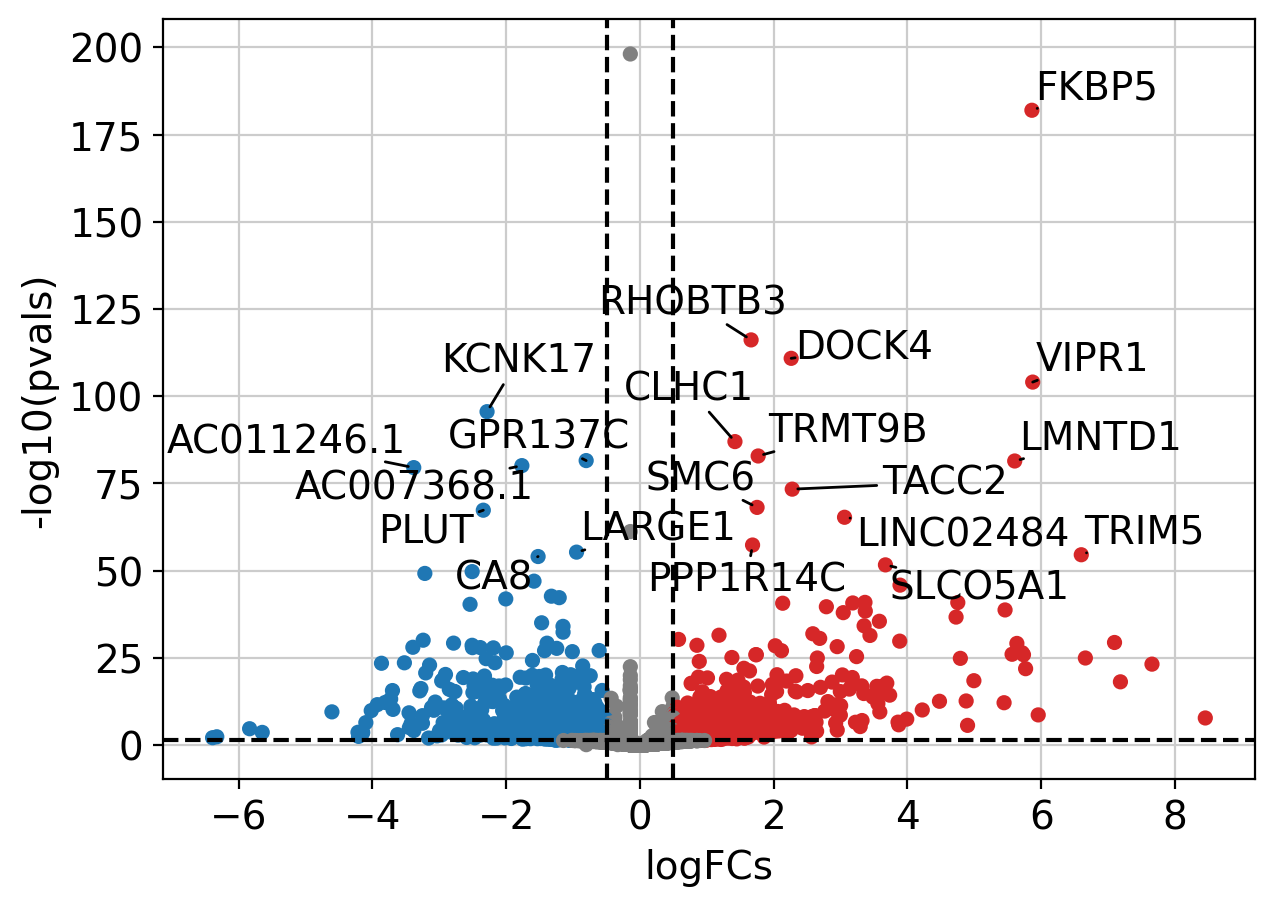

In [123]:
# Replot the volcano plot to make sure it looks good
dc.plot_volcano_df(
    results_df, 
    x='log2FoldChange', 
    y='padj', 
    top=20, 
)

In [124]:
mat = results_df[['stat']].T.rename(index={'stat': cell_type})
mat

,PARP9,FKBP5,RHOBTB3,DOCK4,VIPR1,KCNK17,CLHC1,TRMT9B,GPR137C,LMNTD1,...,ANKRD13C,TRMT11,ARHGAP29,TMCO6,MRPS10,AC090559.2,ACTN4,CAPZA2,MED10,SLC22A3
SC_beta,30.399783,29.129742,23.344303,22.805419,22.098437,-21.189744,20.230408,19.749722,-19.589756,19.570455,...,-0.00105,-0.001027,-0.000963,0.00039,-0.000541,-0.000167,0.000479,-0.000203,0.000286,7.948962


# TF activity analysis

In [125]:
# Retrieve GRN
if tf_annotation_resource == "dorothea":
    net = dc.get_dorothea(organism='human', split_complexes=False)
else:
    raise ValueError(f"tf_annotation_resource {tf_annotation_resource} not supported")
net.head()

,source,confidence,target,weight
0,MYC,A,TERT,1.0
1,FOS,A,NTS,1.0
2,FOS,A,NTF3,1.0
3,FOS,A,NFKB1,-1.0
4,FOS,A,NEFL,1.0


In [126]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=dorothea)
tf_acts

,AHR,AR,ARID2,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
SC_beta,-3.073543,1.696916,0.28277,0.554942,0.473125,0.130305,-1.018513,-1.945644,1.070743,0.262277,...,-1.999532,1.778363,4.592111,-0.217522,1.162202,0.370569,1.494758,0.985115,-1.14147,1.735815


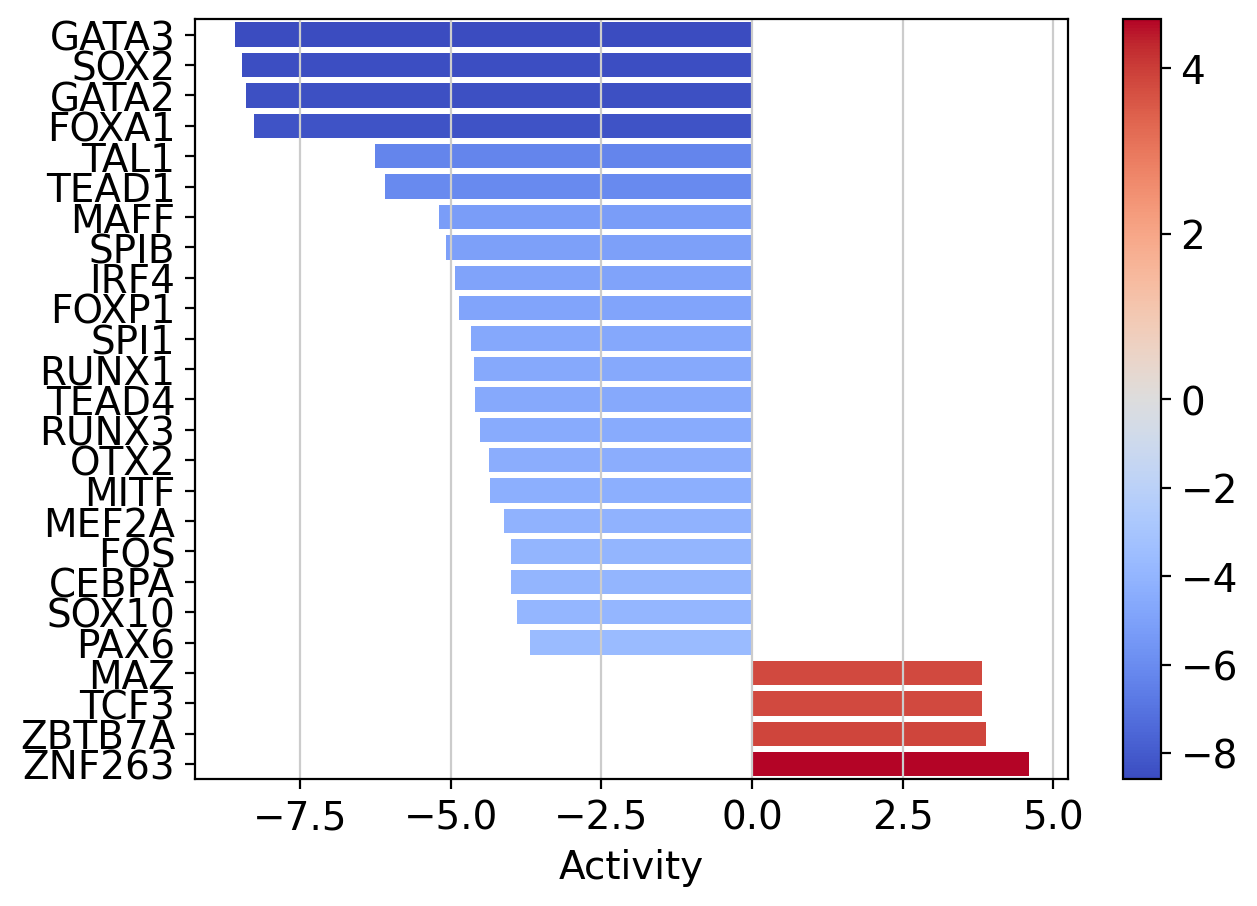

In [127]:
# Plot the TF activity barplot
dc.plot_barplot(tf_acts, cell_type, top=25, vertical=True, save=os.path.join(out_dir, f"{cell_type}_{condition}_tf_activity_barplot.png"))

In [128]:
# Save the TF activity table
tf_acts.T.to_csv(os.path.join(out_dir, f"{cell_type}_{condition}_tf_activity.tsv"), sep="\t")

# Pathway activity analysis

In [129]:
# Retrieve weights
if pathway_annotation_resource == "progeny":
    net = dc.get_progeny(top=pathway_additional_args["top"])
else:
    raise ValueError(f"pathway_annotation_resource {pathway_annotation_resource} not supported")
net.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


In [130]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
SC_beta,5.144003,0.081569,-0.467625,1.438129,0.753457,1.303516,-1.487501,-2.20364,-5.291573,-0.314695,-3.026792,-0.031827,2.231961,-0.897641


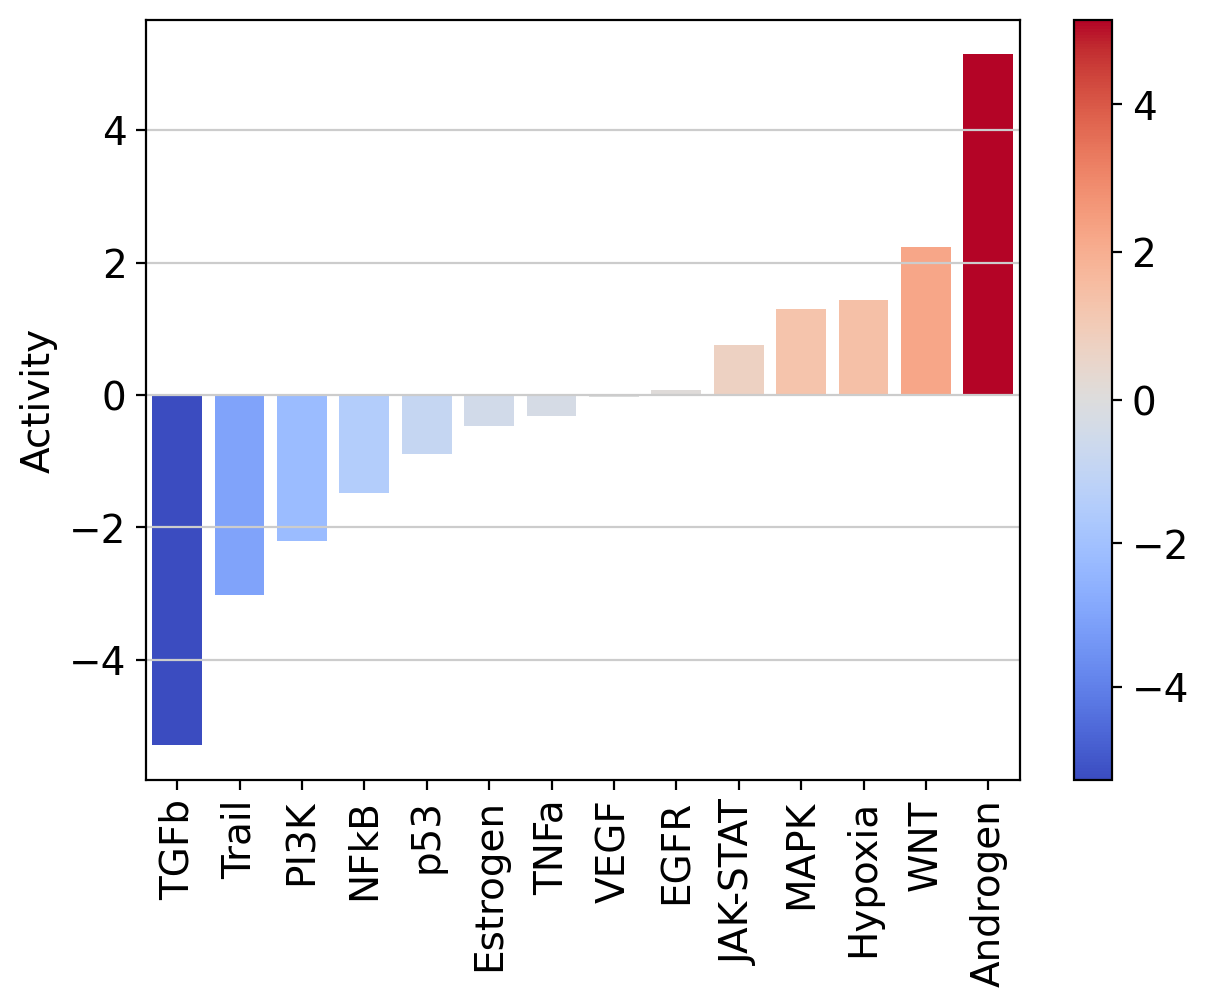

In [131]:
# Plot a barplot of the pathway activities
dc.plot_barplot(pathway_acts, cell_type, top=25, vertical=False, save=os.path.join(out_dir, f"{cell_type}_{condition}_pathway_activity_barplot.png"))

In [132]:
# Save the pathway activities to a file
pathway_acts.T.to_csv(os.path.join(out_dir, f"{cell_type}_{condition}_pathway_activity.tsv"), sep="\t")

# Gene set enrichment analysis

In [133]:
# Retrieve resource
if gsea_resource == "msigdb":
    gene_sets = dc.get_resource('MSigDB')
    
# Filter by hallmark
    gene_sets = gene_sets[gene_sets['collection'] == 'hallmark']

    # Remove duplicated entries
    gene_sets = gene_sets[~gene_sets.duplicated(['geneset', 'genesymbol'])]

    # Rename
    gene_sets.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in gene_sets['geneset']]
else:
    raise ValueError(f"gsea_resource {gsea_resource} not supported")
gene_sets.head()

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT


In [134]:
# Infer enrichment with ora using significant deg
if gsea_additional_args["padj"] is None:
    assert gsea_additional_args["top_n"] is not None
    top_genes = results_df.sort_values("padj").iloc[:gsea_additional_args["top_n"]]
else:
    top_genes = results_df[results_df['padj'] < 0.05]
print(top_genes.shape)
top_genes.head()

(2625, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
PARP9,161.28966,-0.144270,0.869305,30.399783,5.529251e-203,7.946086e-199
FKBP5,1768.14840,5.860374,0.199772,29.129742,1.508596e-186,1.084001e-182
RHOBTB3,572.68866,1.661522,0.071481,23.344303,1.574587e-120,7.542795e-117
DOCK4,847.22700,2.260946,0.099403,22.805419,4.051231e-115,1.455506e-111
VIPR1,136.99470,5.872192,0.266074,22.098437,3.271956e-108,9.404255e-105


In [135]:
# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=gene_sets,
    source='geneset',
    target='genesymbol'
)
enr_pvals.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,200,0.135000,0.468927,0.887813,1.045133,0.791489,ABCA1;ABCB8;ATP1B3;BCKDHA;BCL6;CD36;COX8A;DLD;...
1,ALLOGRAFT_REJECTION,200,0.075000,0.995862,0.995862,0.586367,0.002432,ACVR2A;APBB1;BRCA1;CCND2;CD4;CD74;GCNT1;HDAC9;...
2,ANDROGEN_RESPONSE,100,0.170000,0.157742,0.394355,1.328450,2.453375,AKAP12;B4GALT1;ELOVL5;FKBP5;HOMER2;INPP4B;ITGA...
3,ANGIOGENESIS,36,0.194444,0.185726,0.442205,1.566658,2.637443,CCND2;ITGAV;NRP1;SLCO2A1;TNFRSF21;VCAN;VTN
4,APICAL_JUNCTION,200,0.165000,0.096839,0.268998,1.276109,2.979335,ADAM23;ADAM9;ADAMTS5;ADRA1B;AMIGO2;B4GALT1;BAI...


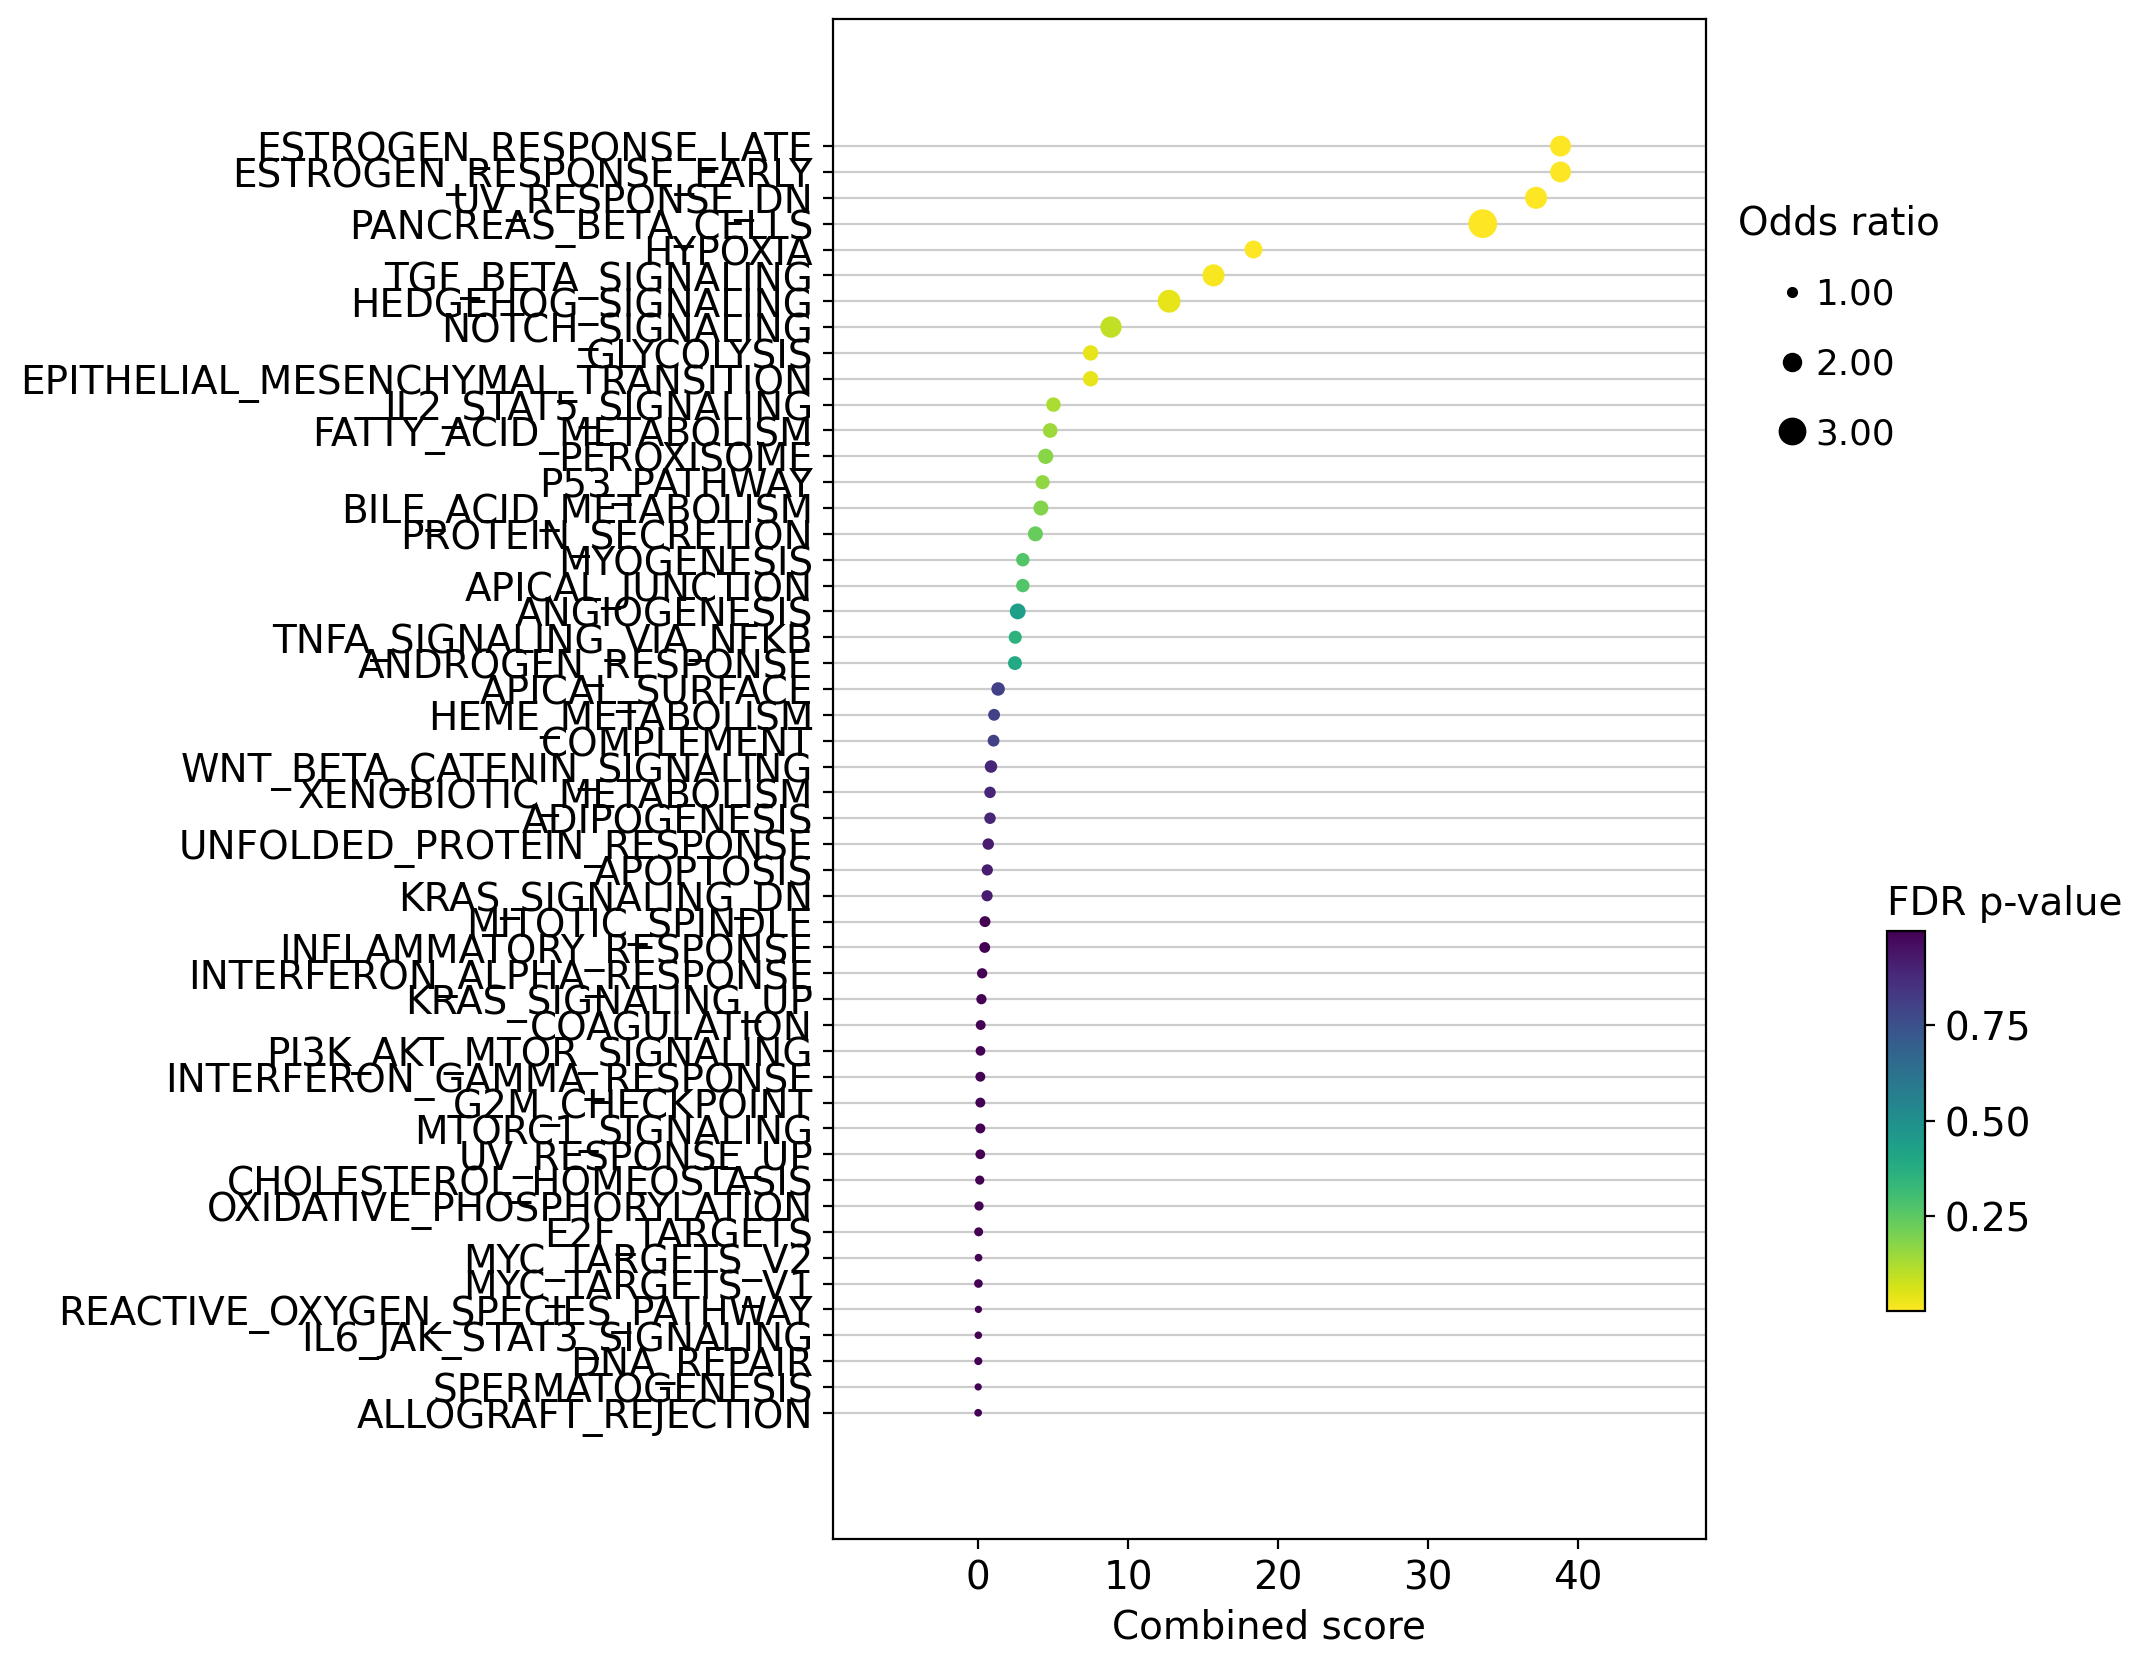

In [136]:
# Plot the dotplot
dc.plot_dotplot(enr_pvals, x='Combined score', y = 'Term', s='Odds ratio', c = 'FDR p-value', scale = 0.5, figsize=(7,10), save=os.path.join(out_dir, f"{cell_type}_{condition}_gsea_dotplot.png"))

In [137]:
# Save the enrichment table
enr_pvals.to_csv(os.path.join(out_dir, f"{cell_type}_{condition}_gsea_enrichment.tsv"), sep="\t")

# DONE!

---

# Scratch

## Close analysis of particular sets
Will likely by separate custom notebook that will vary a lot from dataset to dataset

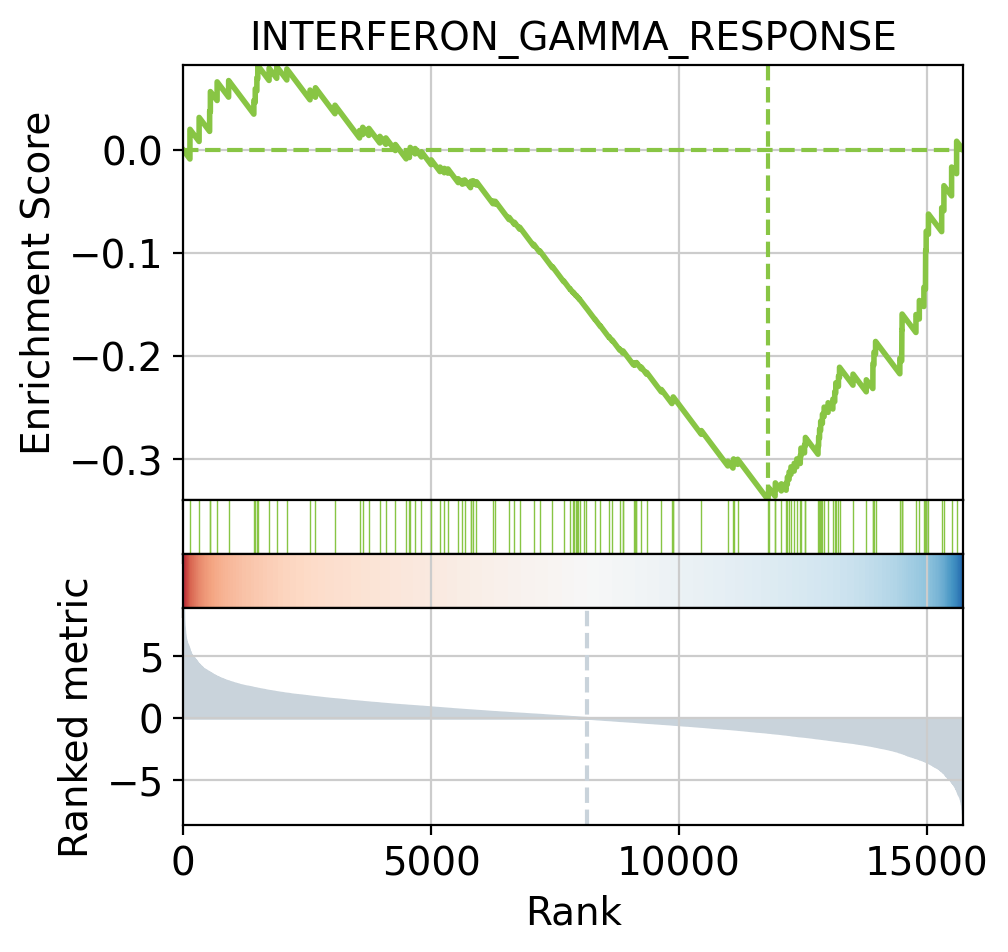

In [ ]:
# Plot
dc.plot_running_score(results_df, stat='stat', net=msigdb, source = 'geneset', target='genesymbol', set_name='INTERFERON_GAMMA_RESPONSE')